## Columns to be removed from training/validation

# Load Tensorflow and check GPU availability

In [7]:
!pip3 install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.9 MB/s eta 0:00:005.7 MB/s eta 0:00:01
  Attempting uninstall: keras
    Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import sys


from tensorflow.python.client import device_lib

for device in device_lib.list_local_devices():
    print(device.physical_device_desc)


    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

2025-04-07 11:41:11.498621: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-07 11:41:11.498699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-07 11:41:11.553524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 11:41:11.661505: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-07 11:41:13.507220: W tensorflow/compiler/tf2


device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
cuda:0


2025-04-07 11:41:18.922340: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-07 11:41:19.094185: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-07 11:41:19.097529: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Load input datasets

In [3]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pandas import DataFrame
from pandas.core.dtypes import common as com
from pyarrow import Table


def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    'parkets/benign/benign_2312_HTML.parquet', 
]
malicious_dataset_filenames = [
    'parkets/phishing_2406_strict_HTML.parquet'
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "phishing"
# #############################################################

# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}



# ===================
# AUTO BALANCING !!!
# Subsample benign to match the size of malicious
# df_benign = df_benign.sample(n=len(df_malicious))
# ===================

# Concatentate benign and malicious
df = pd.concat([df_benign, df_malicious])


def cast_timestamp(df: DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)

    return df

df = cast_timestamp(df)

# Handle NaNs
df.fillna(-1, inplace=True)


# SUBSAMPLE1 (OPTIONAL)
subsample = 0.05 # 1.0 means no subsample
if subsample < 1.0:
    df = df.sample(frac=subsample)

# Drop the domain name column
df.drop("domain_name", axis=1, inplace=True)

        




labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix



print(f"Total features after augmentation: {features.shape[1]}")

print(f"Total samples: {len(df)}")
print(f"Benign count: {len(df_benign)}")
print(f"Malicious count: {len(df_malicious)}")



df

Total features after augmentation: 263
Total samples: 31331
Benign count: 462192
Malicious count: 164425


,label,dns_has_dnskey,dns_A_count,dns_AAAA_count,dns_MX_count,dns_NS_count,dns_TXT_count,dns_SOA_count,dns_CNAME_count,dns_zone_level,...,html_index_of,html_document_write,html_get,html_find,html_document_create_element,html_window_set_timeout,html_window_set_interval,html_hex_encoding,html_unicode_encoding,html_long_variable_name
444005,benign,0.0,1,0,0,0,0,0,0,0,...,0,0,0,2,1,0,0,0,0,1
437815,benign,0.0,2,2,2,2,6,1,0,0,...,0,0,0,0,0,0,0,0,3,17
391218,benign,1.0,1,0,5,2,4,1,0,0,...,0,1,0,0,0,0,0,0,0,4
14361,benign,1.0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
293000,benign,0.0,1,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5313,benign,0.0,1,0,0,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4
140900,phishing,0.0,2,2,0,0,0,0,0,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
75772,benign,0.0,1,0,1,4,4,1,0,0,...,9,0,26,0,2,0,0,0,0,58
176794,benign,0.0,2,0,1,2,14,1,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


# Data preprocessing

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib
 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
features = pd.DataFrame(scaled_data, columns=features.columns)

# Save the scaler
joblib.dump(scaler, "scalers/phishing_deepnn_scaler.joblib")

pd.set_option('display.max_columns', None)
features

,dns_has_dnskey,dns_A_count,dns_AAAA_count,dns_MX_count,dns_NS_count,dns_TXT_count,dns_SOA_count,dns_CNAME_count,dns_zone_level,dns_zone_digit_count,dns_zone_len,dns_zone_entropy,dns_resolved_record_types,dns_dnssec_score,dns_ttl_avg,dns_ttl_stdev,dns_ttl_low,dns_ttl_mid,dns_ttl_distinct_count,dns_soa_primary_ns_level,dns_soa_primary_ns_digit_count,dns_soa_primary_ns_len,dns_soa_primary_ns_entropy,dns_soa_email_level,dns_soa_email_digit_count,dns_soa_email_len,dns_soa_email_entropy,dns_soa_refresh,dns_soa_retry,dns_soa_expire,dns_soa_min_ttl,dns_domain_name_in_mx,dns_mx_avg_len,dns_mx_avg_entropy,dns_txt_avg_len,dns_txt_avg_entropy,dns_txt_external_verification_score,dns_txt_spf_exists,dns_txt_dkim_exists,dns_txt_dmarc_exists,ip_count,ip_mean_average_rtt,ip_v4_ratio,ip_a_aaaa_to_all_ratio,ip_entropy,ip_as_address_entropy,ip_asn_entropy,ip_distinct_as_count,tls_has_tls,tls_chain_len,tls_is_self_signed,tls_root_authority_hash,tls_leaf_authority_hash,tls_negotiated_version_id,tls_negotiated_cipher_id,tls_root_cert_validity_len,tls_leaf_cert_validity_len,tls_broken_chain,tls_expired_chain,tls_total_extension_count,tls_critical_extensions,tls_with_policies_crt_count,tls_percentage_crt_with_policies,tls_x509_anypolicy_crt_count,tls_iso_policy_crt_count,tls_joint_isoitu_policy_crt_count,tls_subject_count,tls_server_auth_crt_count,tls_client_auth_crt_count,tls_CA_certs_in_chain_ratio,tls_unique_SLD_count,tls_common_name_count,lex_name_len,lex_has_digit,lex_phishing_keyword_count,lex_benign_keyword_count,lex_consecutive_chars,lex_tld_len,lex_tld_abuse_score,lex_tld_hash,lex_sld_len,lex_sld_norm_entropy,lex_sld_digit_count,lex_sld_digit_ratio,lex_sld_phishing_keyword_count,lex_sld_vowel_count,lex_sld_vowel_ratio,lex_sld_consonant_count,lex_sld_consonant_ratio,lex_sld_non_alphanum_count,lex_sld_non_alphanum_ratio,lex_sld_hex_count,lex_sld_hex_ratio,lex_sub_count,lex_stld_unique_char_count,lex_begins_with_digit,lex_www_flag,lex_sub_max_consonant_len,lex_sub_norm_entropy,lex_sub_digit_count,lex_sub_digit_ratio,lex_sub_vowel_count,lex_sub_vowel_ratio,lex_sub_consonant_count,lex_sub_consonant_ratio,lex_sub_non_alphanum_count,lex_sub_non_alphanum_ratio,lex_sub_hex_count,lex_sub_hex_ratio,lex_phishing_bigram_matches,lex_phishing_trigram_matches,lex_phishing_tetragram_matches,lex_phishing_pentagram_matches,lex_malware_bigram_matches,lex_malware_trigram_matches,lex_malware_tetragram_matches,lex_dga_bigram_matches,lex_dga_trigram_matches,lex_dga_tetragram_matches,lex_avg_part_len,lex_stdev_part_lens,lex_longest_part_len,lex_short_part_count,lex_medium_part_count,lex_long_part_count,lex_superlong_part_count,lex_shortest_sub_len,lex_ipv4_in_domain,lex_has_trusted_suffix,lex_has_wellknown_suffix,lex_has_cdn_suffix,lex_has_vps_suffix,lex_has_img_suffix,lex_suffix_score,geo_countries_count,geo_continents_count,geo_malic_host_country,geo_lat_stdev,geo_lon_stdev,geo_mean_lat,geo_mean_lon,geo_min_lat,geo_max_lat,geo_min_lon,geo_max_lon,geo_lat_range,geo_lon_range,geo_centroid_lat,geo_centroid_lon,geo_estimated_area,geo_continent_hash,geo_countries_hash,rdap_registration_period,rdap_domain_age,rdap_time_from_last_change,rdap_domain_active_time,rdap_has_dnssec,rdap_registrar_name_len,rdap_registrar_name_entropy,rdap_registrar_name_hash,rdap_registrant_name_len,rdap_registrant_name_entropy,rdap_admin_name_len,rdap_admin_name_entropy,rdap_admin_email_len,rdap_admin_email_entropy,rdap_ip_v4_count,rdap_ip_v6_count,rdap_ip_shortest_v4_prefix_len,rdap_ip_longest_v4_prefix_len,rdap_ip_shortest_v6_prefix_len,rdap_ip_longest_v6_prefix_len,rdap_ip_avg_admin_name_len,rdap_ip_avg_admin_name_entropy,rdap_ip_avg_admin_email_len,rdap_ip_avg_admin_email_entropy,html_num_of_tags,html_num_of_paragraphs,html_num_of_divs,html_num_of_titles,html_num_of_external_js,html_num_of_links,html_num_of_scripts,html_num_of_scripts_async,html_num_of_scripts_type,html_num_of_anchors,html_num_of_anchors_to_hash,html_num_of_anchors_to_https,html_num_of_anchors_to_com,html_num_of_inputs,html

# Train-test split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
  features,
  labels,
  test_size=0.2,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

# print number of features
print(X_train.shape[1])

263


# Define the NN model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(23,)))
#model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(65, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=[Precision(), Recall(), AUC()]
)

2025-02-16 20:17:34.800843: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-16 20:17:34.808660: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-16 20:17:34.815582: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

TypeError: Unexpected keyword argument passed to optimizer: learning_rate

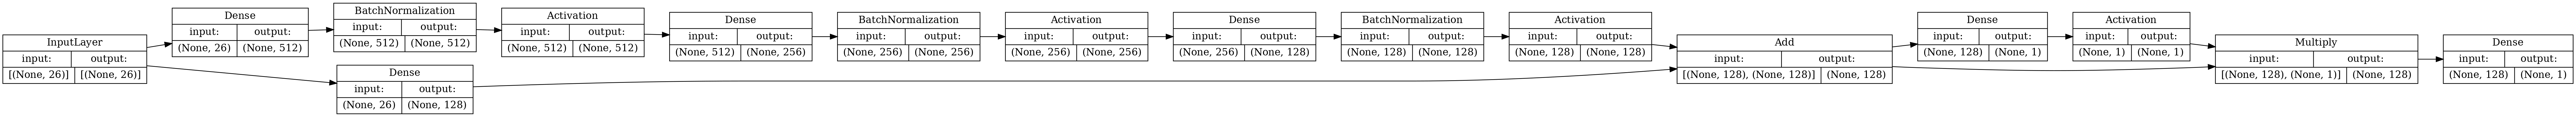

In [7]:
settings = {
    # ALL LAYERS
    'MAX_NEURONS': 3,
}

from tensorflow.keras.utils import plot_model

# Save the model visualization
plot_model(
    model,
    to_file='compact_graph.png',
    show_shapes=True,
    show_layer_names=False,
    dpi=196,  # Adjust DPI for higher/lower resolution
    expand_nested=False,  # Makes complex models more compact
    rankdir='LR'  # Use 'LR' for a horizontal layout, 'TB' for vertical
)

# Display the image
from IPython.display import Image
Image(filename='compact_graph.png')



In [13]:
from sklearn.utils import class_weight

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Calculate class weights
class_weights = {0: 1.0, 1: 1.0} 

history = model.fit(
    X_train,
    Y_train,
    batch_size=512,
    epochs=20,
    validation_data=(X_test, Y_test),  # Provide validation data
    class_weight=class_weights,  # Apply class weights here
    callbacks=[early_stopping]  # Add early stopping callback
)


Epoch 1/20
980/980 [==============================] - 11s 12ms/step - loss: 0.5045 - precision: 0.6501 - recall: 0.1189 - auc: 0.7187 - val_loss: 0.5045 - val_precision: 0.6083 - val_recall: 0.1638 - val_auc: 0.7200
Epoch 2/20
980/980 [==============================] - 10s 10ms/step - loss: 0.5026 - precision: 0.6407 - recall: 0.1274 - auc: 0.7205 - val_loss: 0.5040 - val_precision: 0.6045 - val_recall: 0.1668 - val_auc: 0.7207
Epoch 3/20
980/980 [==============================] - 8s 8ms/step - loss: 0.5024 - precision: 0.6418 - recall: 0.1288 - auc: 0.7208 - val_loss: 0.5026 - val_precision: 0.6103 - val_recall: 0.1634 - val_auc: 0.7216
Epoch 4/20
980/980 [==============================] - 9s 9ms/step - loss: 0.5019 - precision: 0.6454 - recall: 0.1248 - auc: 0.7214 - val_loss: 0.5034 - val_precision: 0.6045 - val_recall: 0.1668 - val_auc: 0.7206
Epoch 5/20
980/980 [==============================] - 9s 9ms/step - loss: 0.5017 - precision: 0.6453 - recall: 0.1268 - auc: 0.7214 - val_lo

In [85]:
print(history.history.keys())
model.save(model_path)

dict_keys(['loss', 'precision_12', 'recall_12', 'auc_12', 'val_loss', 'val_precision_12', 'val_recall_12', 'val_auc_12'])


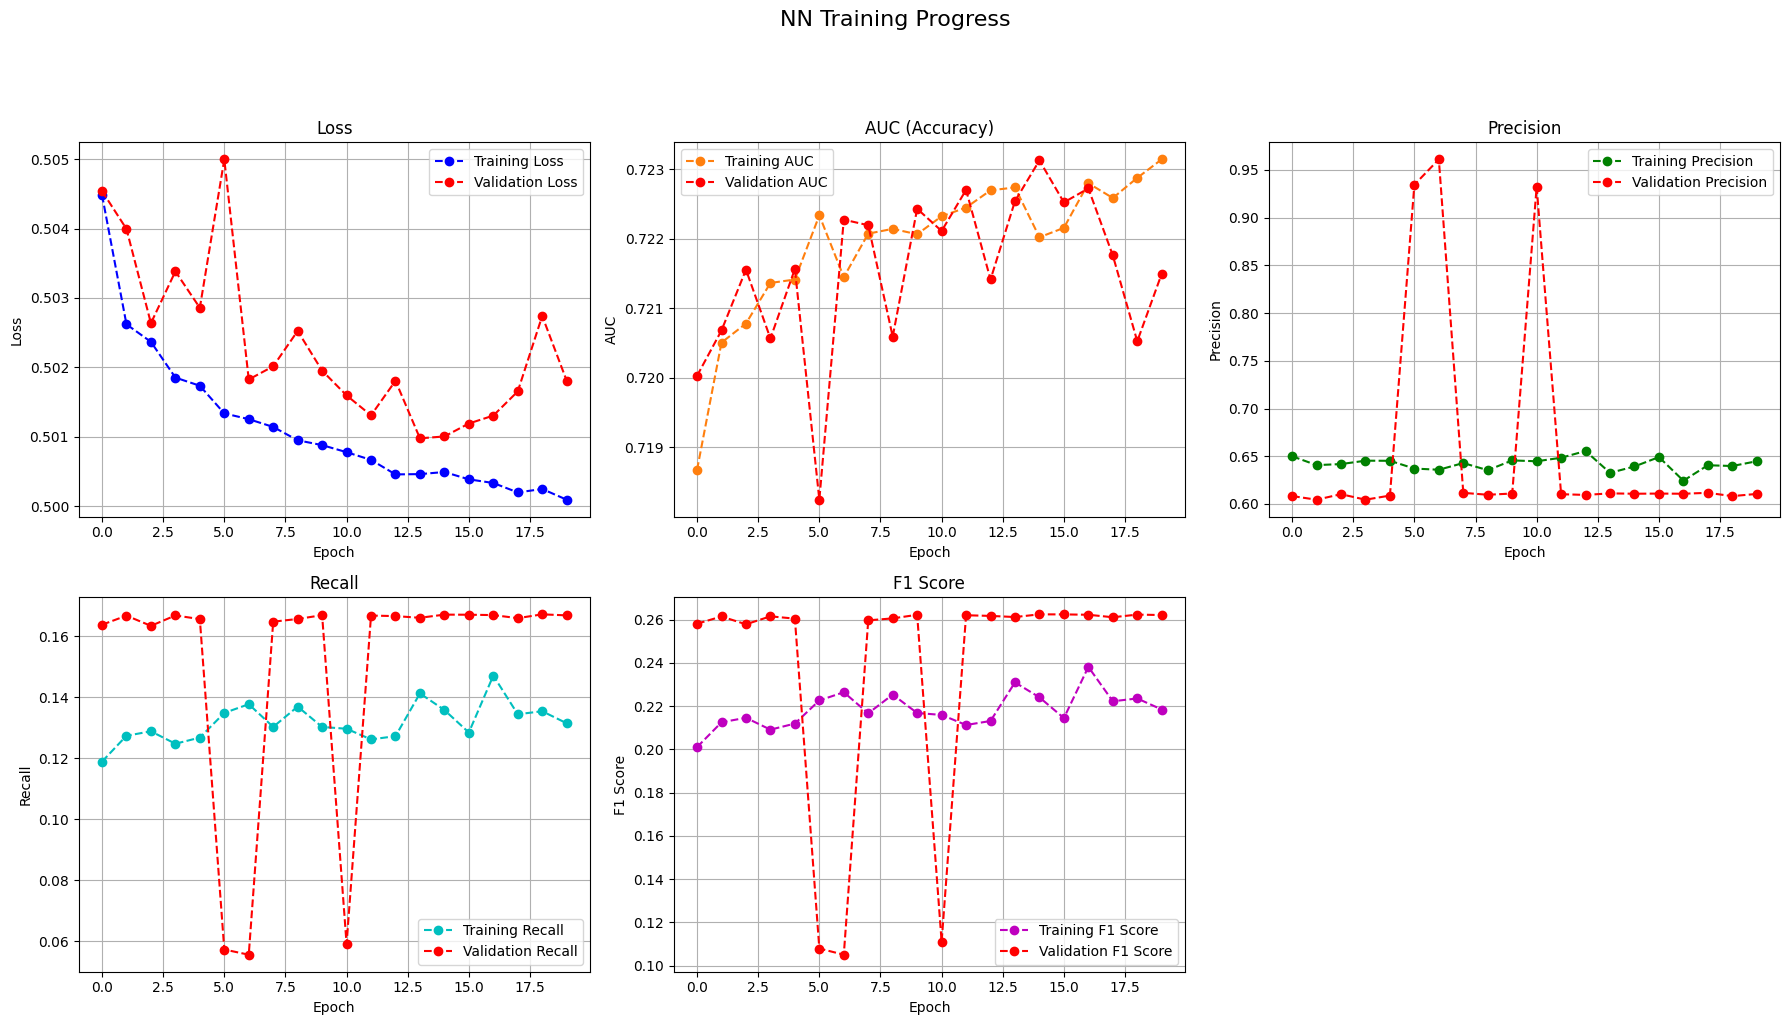

In [14]:
def get_metric(history, metric_name):
    if metric_name in history.history:
        return history.history[metric_name]
    elif f"{metric_name}_12" in history.history:
        return history.history[f"{metric_name}_12"]
    elif f"{metric_name}_2" in history.history:
        return history.history[f"{metric_name}_2"]
    else:
        raise KeyError(f"Metric {metric_name} not found in history.")

epoch_losses = get_metric(history, 'loss')
epoch_val_losses = get_metric(history, 'val_loss')
epoch_accuracies = get_metric(history, 'auc')
epoch_val_accuracies = get_metric(history, 'val_auc')
epoch_precisions = get_metric(history, 'precision')
epoch_val_precisions = get_metric(history, 'val_precision')
epoch_recalls = get_metric(history, 'recall')
epoch_val_recalls = get_metric(history, 'val_recall')

# Calculate F1 score
epoch_f1s = [2 * (p * r) / (p + r) for p, r in zip(epoch_precisions, epoch_recalls)]
epoch_val_f1s = [2 * (p * r) / (p + r) for p, r in zip(epoch_val_precisions, epoch_val_recalls)]

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

# Plot for Loss
plt.subplot(2, 3, 1)
plt.plot(epoch_losses, linestyle='--', marker='o', color='b', label='Training Loss')
plt.plot(epoch_val_losses, linestyle='--', marker='o', color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

# Plot for AUC (as a proxy for Accuracy)
plt.subplot(2, 3, 2)
plt.plot(epoch_accuracies, linestyle='--', marker='o', color='#ff7f0e', label='Training AUC')
plt.plot(epoch_val_accuracies, linestyle='--', marker='o', color='r', label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC (Accuracy)')
plt.legend()
plt.grid(True)

# Plot for Precision
plt.subplot(2, 3, 3)
plt.plot(epoch_precisions, linestyle='--', marker='o', color='g', label='Training Precision')
plt.plot(epoch_val_precisions, linestyle='--', marker='o', color='r', label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()
plt.grid(True)

# Plot for Recall
plt.subplot(2, 3, 4)
plt.plot(epoch_recalls, linestyle='--', marker='o', color='c', label='Training Recall')
plt.plot(epoch_val_recalls, linestyle='--', marker='o', color='r', label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()
plt.grid(True)

# Plot for F1 Score
plt.subplot(2, 3, 5)
plt.plot(epoch_f1s, linestyle='--', marker='o', color='m', label='Training F1 Score')
plt.plot(epoch_val_f1s, linestyle='--', marker='o', color='r', label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()
plt.grid(True)

plt.suptitle('NN Training Progress', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('nn_training_progress.png', dpi=500, bbox_inches='tight', pad_inches=0.5)
plt.show()


3917/3917 [==============================] - 3s 863us/step - loss: 0.5018 - precision: 0.6105 - recall: 0.1669 - auc: 0.7215
Loss =  0.5018086433410645
Accuracy =  0.6105485558509827
3917/3917 [==============================] - 3s 684us/step

=== RESULTS ===
              precision    recall  f1-score   support

      Benign     0.7645    0.9621    0.8520     92439
   Malicious     0.6105    0.1669    0.2621     32885

    accuracy                         0.7535    125324
   macro avg     0.6875    0.5645    0.5570    125324
weighted avg     0.7241    0.7535    0.6972    125324

False Positive Rate = 0.03786280682395959

Confusion Matrix:
[[88939  3500]
 [27398  5487]]


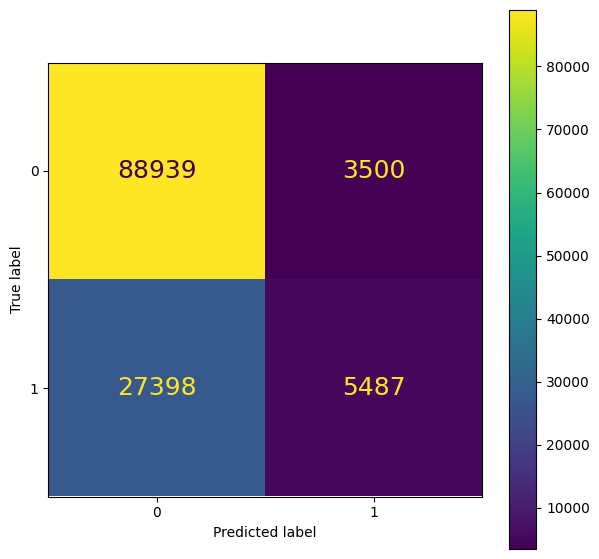

In [15]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
loss_and_metrics = model.evaluate(X_test, Y_test)
print('Loss = ', loss_and_metrics[0])
print('Accuracy = ', loss_and_metrics[1])

# Generate predictions
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred).astype(int)  # Convert probabilities to binary predictions

# Calculate additional metrics
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# False Positive Rate
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)

# Display the metrics
print('\n=== RESULTS ===')
print(classification_report(Y_test, Y_pred, target_names=['Benign', 'Malicious'], digits=4))
print('False Positive Rate =', fpr)


# Display the confusion matrix
print('\nConfusion Matrix:')
print(cm)

# Optionally, plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(7, 7))  # Increase figure size for better readability
disp.plot(ax=ax, values_format='d')
for labels in disp.text_:
    for label in labels:
        label.set_fontsize(18) 
plt.show()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Permutation explainer: 1001it [02:35,  6.36it/s]                          
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


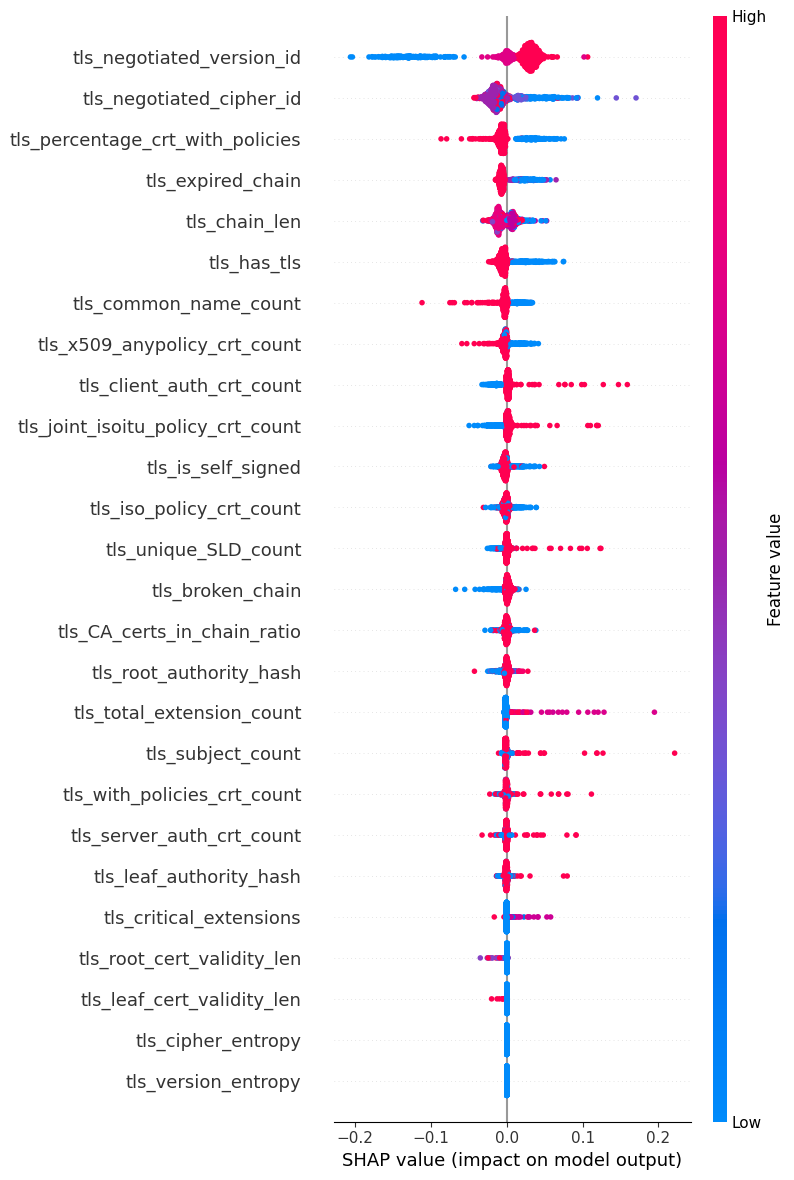

In [11]:
analyze_feature_importance = True

if analyze_feature_importance:
    
    import shap
    
    # Ensure that X_train and X_test are DataFrames with the correct column names
    # You can set the column names from the 'features' DataFrame like this:
    X_train.columns = features.columns
    X_test.columns = features.columns
    
    n_samples = 1000
    
    # Convert your training set to a NumPy format if it's not already
    background = X_train[:n_samples].to_numpy()
    
    # Use the generic SHAP Explainer interface
    explainer = shap.Explainer(model, background)
    
    # Generate SHAP values for the test set
    shap_values = explainer(X_test[:n_samples].to_numpy())
    
    # Plotting the summary plot for feature importance
    # Use the column names from the 'features' DataFrame as the feature names
    shap.summary_plot(shap_values.values, X_test[:n_samples], feature_names=features.columns, max_display=30)
